# A/B Testing Project (Part of Final Project)

## Project Description

You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit. They left only the technical specifications and the test results.

## Technical description

**Test name:** recommender_system_test (upd: interface_eu_test) <br>
**Groups:** А (control), B (new payment funnel) <br>
**Launch date:** 2020-12-07 <br>
**Date when they stopped taking up new users:** 2020-12-21 (upd: 2020-12-23) <br>
**End date:** 2021-01-01 (upd: 2020-12-30) <br>
**Audience:** 15% of the new users from the EU region (upd: 23%) <br>
**Purpose of the test:** testing changes related to the introduction of an improved recommendation system <br>
**Expected result:** within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase. <br>
**Expected number of test participants:** 6000 (upd: 10850)

## Our Goals

1. Define whether the A/B test was run correctly
2. Interpret the results
3. Give recommendations

## Plan of work:

1. Download the data and study [general informaton](#part1) <br>
2. [Data preprocessing](#part2) <br>
3. Exploratory data analysis: <br>
    3.1. [Conversion funnel](#part3_1) <br>
    3.2. [Samples division and equality](#part3_2) <br>
    3.3. [Events distribution among samples](#part3_3) <br>
4. A/B test results: <br>
    4.1. [Test results](#part4_1) <br>
    4.2. [z-test](#part4_2) about difference of populations <br>
5. [General conclusions](#part5)

### Download the data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_style('darkgrid')

In [4]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv', parse_dates = ['start_dt', 'finish_dt'])
new_users = pd.read_csv('/datasets/final_ab_new_users_us.csv', parse_dates = ['first_date'])
events = pd.read_csv('/datasets/final_ab_events_us.csv', parse_dates = ['event_dt'])
participants = pd.read_csv('/datasets/final_ab_participants_us.csv')

In [5]:
dfs = [marketing_events, new_users, events, participants]

<a id='part1'></a>
### General Information

In [6]:
for i in dfs:
    display(i.sample(5))
    display(i.info())

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null datetime64[ns]
finish_dt    14 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None

,user_id,first_date,region,device
23487,8435CA0433862A69,2020-12-15,EU,PC
34416,470937DA608D491E,2020-12-10,EU,iPhone
9219,75B218EDB7D0F8A4,2020-12-14,EU,Android
39632,A351ADA4B7B0DDE8,2020-12-11,EU,Android
4945,88A18391A6F0A2C9,2020-12-07,CIS,Android


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null datetime64[ns]
region        61733 non-null object
device        61733 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None

,user_id,event_dt,event_name,details
380558,F3B381BEAA0735DC,2020-12-22 02:40:18,login,NaN
125029,BE2E7FE6B18B9CD1,2020-12-29 16:13:07,product_cart,NaN
143742,F08E0A115537BBBB,2020-12-12 10:40:48,product_page,NaN
63183,C59B1E478A22FBE9,2020-12-07 17:57:15,product_cart,NaN
409463,EA2552A9FD0E9183,2020-12-24 08:45:12,login,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null datetime64[ns]
event_name    440317 non-null object
details       62740 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None

,user_id,group,ab_test
11593,5D39A624FB8264BA,B,interface_eu_test
17529,9AE73C8017160225,A,interface_eu_test
13792,31ADC56FED418CC7,A,interface_eu_test
14356,A4145A2EA1E17654,B,interface_eu_test
9726,50DE09293D49A0C1,B,interface_eu_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


None

<a id='part2'></a>
### Data preprocessing

In [7]:
#checking for duplicated rows
for i in dfs:
    print("There's no duplicates in dataframe:", i[i.duplicated()].empty)

There's no duplicates in dataframe: True
There's no duplicates in dataframe: True
There's no duplicates in dataframe: True
There's no duplicates in dataframe: True


In [8]:
#checking column with missing values
events.groupby('event_name')['details'].unique()

event_name
login                                 [nan]
product_cart                          [nan]
product_page                          [nan]
purchase        [99.99, 9.99, 4.99, 499.99]
Name: details, dtype: object

We changed data type for columns with dates while downloading the data, this saved us some space. <br>
There are no duplicated rows in any of our tables. <br>
There are missing values in 'details' column of 'events' table. There are only 4 kinds of events, and only for one of them ('purchase') we have detailed information ('amount of purchase'), so this is okay.

Now we'll check dates distribution.

In [9]:
new_users['first_date'].describe()

count                   61733
unique                     17
top       2020-12-21 00:00:00
freq                     6290
first     2020-12-07 00:00:00
last      2020-12-23 00:00:00
Name: first_date, dtype: object

In [10]:
events['event_dt'].describe()

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

In [11]:
print((new_users[new_users['region'] == 'EU']['user_id'].nunique()) * 0.15)
print(10850 / (new_users[new_users['region'] == 'EU']['user_id'].nunique()))

6940.5
0.2344931921331316


We found a mistake in technical description, 'new_users' dataframe contains users who signed up between December, 7, and December, 23 (not December, 21). <br>
Similar mistake with 'events' dataframe, it contains events between December, 7 and December, 30 (not January, 1). <br>
There's another mistake in audience description - it's actually 23% of new users from EU region, not 15%.

Now we'll work with participants table, removing the participants of another A/B test, which is still running (this is yet another mistake in technical description, we have enough data to analyze 'interface_eu_test', not the one mentioned in description).

In [12]:
#leaving only 'interface_eu_test' in participants table
participants = participants[participants['ab_test'] == 'interface_eu_test']
participants = participants.drop('ab_test', axis=1)

In [13]:
participants.sample(5)

,user_id,group
10314,1EC381865A4F0DBD,B
12930,055CF44C0EDA0EAF,B
9160,3AB5CD276CE1A154,A
15203,ADFDD52AAB96BAEB,A
11839,2515765D8DAF561C,B


In [14]:
participants.groupby('group')['user_id'].nunique()

group
A    5831
B    5736
Name: user_id, dtype: int64

In [15]:
print('Checking intersection of "events" and "participants" dataframes:')
print('Unique user ids in "events":', events['user_id'].nunique())
print('Unique user ids in "participants":', participants['user_id'].nunique())
print('Unique user ids presented in both dataframes:', 
      len(set(participants['user_id'].unique().tolist()).intersection(events['user_id'].unique().tolist())))

Checking intersection of "events" and "participants" dataframes:
Unique user ids in "events": 58703
Unique user ids in "participants": 11567
Unique user ids presented in both dataframes: 10850


What we've discovered is that although we have data on 61733 users who signed up from December 7 to 21, we only have data on events of 58703 unique users. We also have 11567 unique users in our A/B test list. While checking the intersection, we found out that we only have data on events of 10850 unique users from A/B test list. Reason for this can be their inactivity (they signed up, were assigned an experiment group id, but weren't active, so there's no event log). <br>
While merging the dataframes into one we'll be working with, we'll go with inner merge, to keep data only on active users.

In [16]:
data = events.merge(participants, on='user_id', how='inner')

In [17]:
print('Checking intersection with "new_users" dataframe:')
print('Unique user ids in our data:', data['user_id'].nunique())
print('Unique user ids also presented in "new_users":', 
      len(set(new_users['user_id'].unique().tolist()).intersection(data['user_id'].unique().tolist())))


Checking intersection with "new_users" dataframe:
Unique user ids in our data: 10850
Unique user ids also presented in "new_users": 10850


In [18]:
data = data.merge(new_users, on='user_id', how='inner')

In [19]:
data.groupby('group')['user_id'].nunique()

group
A    5467
B    5383
Name: user_id, dtype: int64

In [20]:
data.sample(10)

,user_id,event_dt,event_name,details,group,first_date,region,device
18696,4A0C127CA8708875,2020-12-23 06:19:11,login,NaN,B,2020-12-14,EU,PC
20967,2FC044300210F89F,2020-12-17 16:42:00,product_page,NaN,B,2020-12-15,EU,Android
31738,2ABDECD3E9D09714,2020-12-21 06:51:23,product_page,NaN,A,2020-12-21,EU,PC
21919,49DB3A481F9A641C,2020-12-16 14:26:36,purchase,4.99,B,2020-12-16,EU,iPhone
4499,D11CC61C6D673143,2020-12-08 08:40:23,login,NaN,A,2020-12-08,EU,Mac
19676,3DDCC65AA0654F70,2020-12-17 06:31:59,purchase,499.99,B,2020-12-15,EU,iPhone
22121,BD31CABB6D5C6561,2020-12-16 17:56:00,purchase,9.99,B,2020-12-16,EU,PC
55112,49FC592FE5F3CB07,2020-12-28 21:04:33,product_page,NaN,A,2020-12-21,EU,PC
25572,30BFD688BABC37DA,2020-12-18 07:43:53,product_cart,NaN,B,2020-12-18,EU,Android
49938,782E66403F309014,2020-12-18 06:01:36,login,NaN,A,2020-12-17,EU,PC


We ended up having 'data' dataframe with events of active participants of A/B test. Number of users in each group is similar (5467 in A group, 5383 in B group), but not equal, and we know that decreases the test's accuracy. There's no point in running an A/A test with these sample sizes.

### Exploratory Data Analysis

<a id='part3_1'></a>
#### Conversion funnel

In [25]:
#conversion funnel for test participants
funnel = data.groupby(['event_name'])['user_id'].nunique()
funnel = funnel.reindex(['login', 'product_page', 'product_cart', 'purchase']).reset_index()
funnel

,event_name,user_id
0,login,10849
1,product_page,7166
2,product_cart,3568
3,purchase,3713


In [26]:
#UPDATED FUNNEL
fig = go.Figure(go.Funnel(x=upd_funnel['user_id'], y=upd_funnel['event_name']))
fig.update_layout(title='Conversion funnel for A/B test participants')
fig.show()

We start from login stage with 10849 unique users; 7166 of them (66.1% of initial amount) get to the second stage and view some product. Then only 3713 users finally purchase something, which is 51.8% of users from previous stage, or 34.2% of initial amount.

UPDATE: We also have 'product_cart' event, which is not necessarily part of the sequence (we have a fast pay button), so only 32.9% of initial users go through product cart.

While conversion of purchase stage seems relatively fair (half of users viewing a product made a purchase), the conversion of the first stage catches attention. We're talking about international online store, so how come of all logged in users only 66% view some product? What happens to other 34% then? Do they log in, and that's it?

<a id='part3_2'></a>
#### Division into experimental groups

In [27]:
#checking for duplicated users (users presented in both experimental groups)
group_A = data[data['group'] == 'A']['user_id'].unique()
group_B = data[data['group'] == 'B']['user_id'].unique()
print('Number of users presented in both groups:', len(set(group_A).intersection(group_B)))

Number of users presented in both groups: 0


In [28]:
#calculating number of events per user for each experimental group
n_events = data.groupby('group').agg({'user_id':'nunique', 'event_dt':'count'}).reset_index()
n_events.columns = ['group', 'users', 'events']
n_events['events_per_user'] = n_events['events'] / n_events['users']
n_events

,group,users,events,events_per_user
0,A,5467,41570,7.603805
1,B,5383,40357,7.497121


<a id='part3_3'></a>
#### Number of events per day

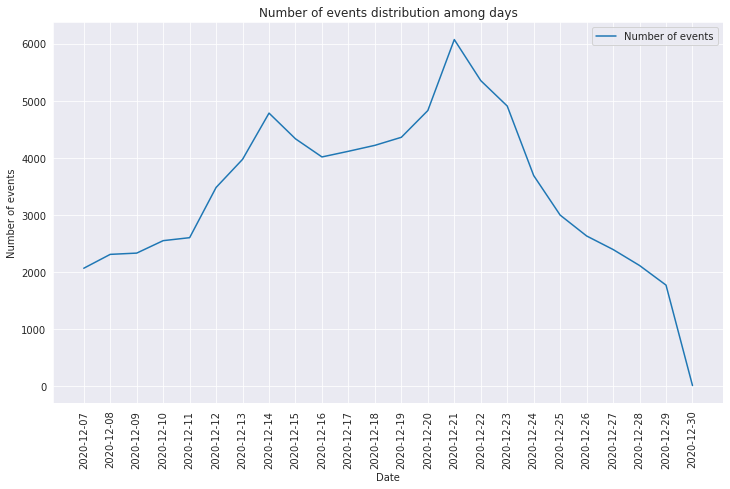

In [29]:
#checking the number of events distribution among days
data['event_date'] = data['event_dt'].dt.date

events_days = data.groupby(['event_date']).agg({'user_id':'nunique', 'event_dt':'count'}).reset_index()
events_days.columns = ['event_date', 'unique_users', 'events']

plt.figure(figsize=(12,7))
plt.title('Number of events distribution among days')
sns.lineplot(data=events_days, x='event_date', y='events', label='Number of events')
plt.xlabel('Date')
plt.xticks(events_days.event_date, rotation=90)
plt.ylabel('Number of events')
plt.show()

First of all, we see that experimental groups were divided correctly, and there are no users presented in both group (which is a good sign, taking into account the amount of mistakes in technical description). <br>
Average number of events per user doesn't differ significantly (7.60 events for group A, 7.49 events for group B), interesting thing is that group B results are supposed to be higher, meanwhile we don't see it. <br>
As for distribution of number of events per day - it's definetely not equal, we see two peaks on 14 and 21 of December. But let's not forget we're talking about December, i.e. Christmas! The whole Europe is buying gifts, so this is probably on of the busiest times of an international online-store. This would explain the rise in activity in middle of the month with slowing down after 21 of December. 

<a id='part4_1'></a>
### A/B Test Results

In [30]:
groups_funnel = data.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index().sort_values(by='A', ascending=False)
groups_funnel['conversion_A'] = ((groups_funnel['A'] / groups_funnel.iloc[0,1]) * 100).round(2)
groups_funnel['conversion_B'] = ((groups_funnel['B'] / groups_funnel.iloc[0,2]) * 100).round(2)
groups_funnel

group,event_name,A,B,conversion_A,conversion_B
0,login,5466,5383,100.00,100.00
2,product_page,3639,3527,66.58,65.52
3,purchase,1931,1782,35.33,33.10
1,product_cart,1756,1812,32.13,33.66


The expected result of the experiment according to description was to see at least 10% rise in conversion for every funnel step in group B(test group). Clearly, we didn't get it here. It's not just that we don't see rise - we even see decrease for group B's conversion rate. What a shame!

<a id='part4_2'></a>
#### Z-test (difference in proportions)

In [31]:
def check_hypothesis(event, alpha=0.05):
    successes1 = groups_funnel[groups_funnel['event_name'] == event]['A'].iloc[0]
    successes2 = groups_funnel[groups_funnel['event_name'] == event]['B'].iloc[0]
    trials1 = data[data['group'] == 'A']['user_id'].nunique()
    trials2 = data[data['group'] == 'B']['user_id'].nunique()
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))
    distr = st.norm(0,1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value:', p_value)
    if (p_value < alpha):
        print('Reject H0 for event', event)
    else:
        print('Failed to reject H0 for event', event)

In [32]:
for i in groups_funnel['event_name'].unique():
    check_hypothesis(i)

p-value: 0.32103485047255065
Failed to reject H0 for event login
p-value: 0.2518419682737163
Failed to reject H0 for event product_page
p-value: 0.014959088807690257
Reject H0 for event purchase
p-value: 0.08746918913258162
Failed to reject H0 for event product_cart


Our H0, null hypothesis, will be "There's no statistically significant difference between conversion in groups A and B, they're the same". Therefore, our H1, alternative hypothesis will be "There is a statistically significant difference between conversion in groups A and B, they're different".

After running the z test, we see that for events 'login' and 'product_page' we failed to reject the null hypothesis, so we can say that the diffrence in conversion on these stages is insignificant. The situation is different for 'purchase' event - there we rejected the null hypothesis, meaning that the diffrence in conversion on this stage is statistically significant.

<a id='part5'></a>
### General Conclusions

After studying the data and the technical description we were left with we can say, that this isn't a good example of an A/B test. First (and important) is the fact that we collected data from online store right before Christmas - this won't allow us to fully trust the results (the impact of external factors on customers' behavior can be too heavy). <br>
Second, there were so many mistakes in technical description, that it makes you trust the data even less. <br>
Third, we have unequal samples, which also affects the test's accuracy. <br>
Overal, we can say that the test wasn't run correctly.

What can we say about the results though? Well, we didn't get any close to the expected result. Conversion rate is pretty much the same, and we even saw significant decrease in conversion on purchase stage for test group B.

In general, at this point I would recommend to stay with the old way (not imply changes) and maybe run the A/B test again after holidays - preparing it better, than the previous analyst did.